In [15]:
!pip install faiss-cpu

In [16]:
import faiss
import numpy as np
import json
import matplotlib.pyplot as plt
from skimage.io import imread
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import funcs 

Descriptores cargados:
- Total descriptores: 15019
- Dimensiones descriptores: 44
- Mapeo de imágenes: 15019
Índice FAISS cargado desde: faiss_index_ivfflat.index
Índice aleatorio seleccionado: 13570


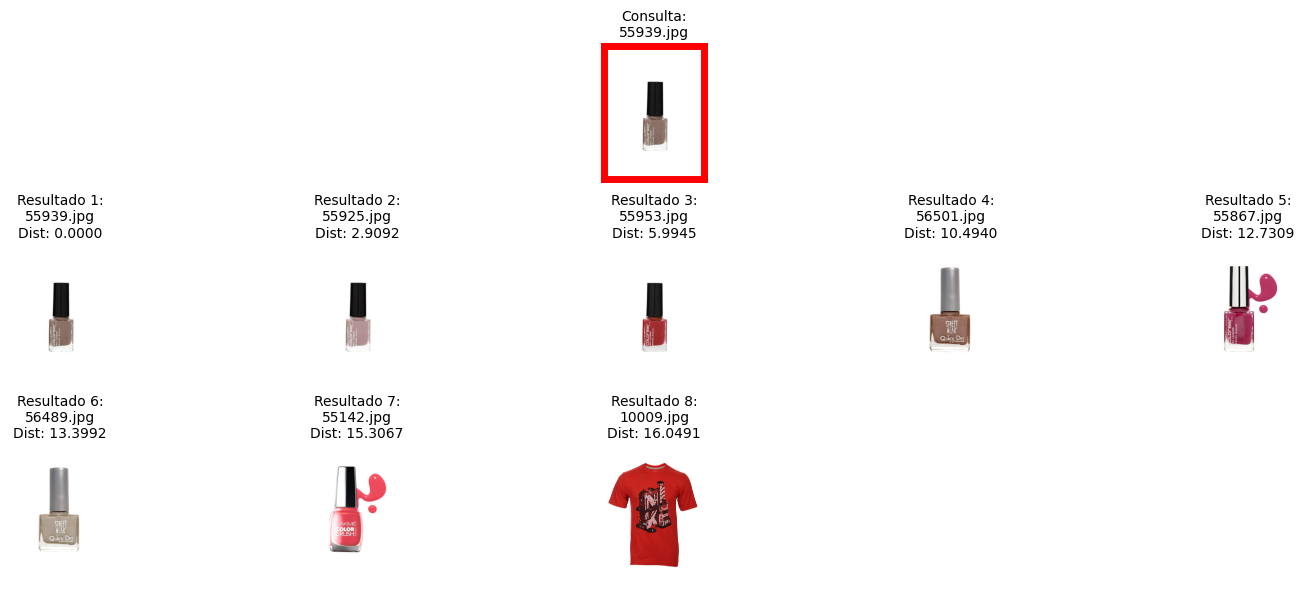

In [29]:
output_dir = "../Extraccion/features15k"
descriptors, mapping = funcs.load_features(output_dir)

print("Descriptores cargados:")
print(f"- Total descriptores: {descriptors.shape[0]}")
print(f"- Dimensiones descriptores: {descriptors.shape[1]}")
print(f"- Mapeo de imágenes: {len(mapping)}")

# Crear índice FAISS en memoria secundaria
def create_faiss_index_on_disk(descriptors, index_path):
    """
    Crea un índice FAISS en disco con IDs asignados.
    """
    d = descriptors.shape[1]  # Dimensión de los descriptores
    quantizer = faiss.IndexFlatL2(d)  # Usamos L2 (distancia Euclidiana)
    index = faiss.IndexIVFFlat(quantizer, d, 100)  # Estructura IVFFlat con 100 centroides
    index.train(descriptors)  # Entrenar el índice
    index.add_with_ids(descriptors, np.arange(descriptors.shape[0]))  # Agregar descriptores con IDs

    # Guardar índice en disco
    faiss.write_index(index, index_path)
    print(f"Índice FAISS creado y guardado en: {index_path}")
    return index

# Cargar índice FAISS desde disco
def load_faiss_index_from_disk(index_path):
    """
    Carga un índice FAISS desde disco.
    """
    index = faiss.read_index(index_path)
    print(f"Índice FAISS cargado desde: {index_path}")
    return index

# KNN usando FAISS
def knn_faiss(query_vector, index, k=8):
    """
    Realiza la búsqueda KNN en FAISS.
    """
    query_vector = query_vector.reshape(1, -1)  # FAISS espera vectores 2D
    distances, indices = index.search(query_vector, k)  # Búsqueda KNN
    results = [(int(indices[0][i]), distances[0][i]) for i in range(k)]
    return results

# Crear o cargar índice FAISS en memoria secundaria
index_path = "faiss_index_ivfflat.index"
if os.path.exists(index_path):
    index = load_faiss_index_from_disk(index_path)
else:
    index = create_faiss_index_on_disk(descriptors, index_path)

# Seleccionar imagen aleatoria como consulta
#random = funcs.select_random_query(descriptors)
random = 13570
query_vector = descriptors[random]
print(f"Índice aleatorio seleccionado: {random}")

# Realizar búsqueda KNN
k = 8
faiss_results = knn_faiss(query_vector, index, k=k)

# Mostrar resultados
funcs.show_results(faiss_results, output_dir, random, k)